# **Prediksi Penutupan Harga Emas dengan Model LSTM**
- **Nama:** Johanadi Santoso
- **Email:** johanadisantoso1@gmail.com
- **ID Dicoding:** johanadisantoso

---
>  Prediksi penutupan harga Emas dengan model LSTM untuk memprediksi harga penutupan emas berdasarkan data historis dari tahun 2020 hingga 2025. Proses dimulai dengan pengunduhan data menggunakan `yfinance`, diikuti oleh analisis kualitas data dan eksplorasi pola historis melalui visualisasi. Data kemudian dinormalisasi menggunakan `MinMaxScaler` dan diubah menjadi format time series dengan pendekatan sliding window. Dataset dibagi menjadi train, validation, dan test untuk memastikan evaluasi yang adil. Model LSTM dibangun dengan tuning hyperparameter menggunakan `Hyperopt`, menghasilkan parameter terbaik seperti jumlah unit LSTM, dropout, learning rate, batch size, dan epochs. Model dilatih dengan teknik regularisasi seperti dropout dan early stopping untuk mencegah overfitting. Evaluasi dilakukan pada data testing menggunakan metrik seperti RMSE, MAE, MAPE, dan R², menunjukkan performa yang cukup baik dalam menangkap pola harga emas secara umum, meskipun terdapat kelemahan dalam menangkap fluktuasi tajam. Model dan scaler disimpan untuk penggunaan di masa depan, menjadikan pipeline ini dapat diotomatisasi untuk prediksi harga emas.



## **1. Install dan Import semua library yang dibutuhkan**

**Langkah**:
- **1.** Menginstal semua library yang diperlukan untuk analisis dan pemodelan, seperti `yfinance`, `pandas`, `numpy`, `matplotlib`, `scikit-learn`, `tensorflow`, `hyperopt`. Library ini mencakup kebutuhan untuk pengolahan data, visualisasi, pemodelan, dan tuning hyperparameter.
- **2.** Mengimpor library yang telah diinstal. Library ini digunakan untuk berbagai fungsi, seperti:
  - `yfinance`: Mengunduh data harga emas.
  - `pandas` dan `numpy`: Pengolahan data.
  - `matplotlib` dan `seaborn`: Visualisasi data.
  - `scikit-learn`: Normalisasi data dan evaluasi model.
  - `tensorflow`: Membangun dan melatih model LSTM.
  - `hyperopt`: Tuning hyperparameter.
  - `random` dan `tf.random`: Menetapkan seed untuk reproducibility.

In [ ]:
# 1. Install library
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow hyperopt  -q

In [ ]:
# 2. Import library
import yfinance as yf
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import random
import numpy as np
import seaborn as sns
import tensorflow as tf


### **1.1. Set Seeds for Reproducibility**

**Tujuan:**
Kode pada cell berikut digunakan untuk menetapkan seed pada berbagai library yang digunakan, sehingga eksperimen dapat direproduksi dengan hasil yang konsisten.

**Penjelasan Kode:**
- **`random.seed(42)`**: Menetapkan seed untuk modul `random` bawaan Python, memastikan hasil operasi acak seperti pengacakan data tetap konsisten.
- **`np.random.seed(42)`**: Menetapkan seed untuk generator angka acak di library NumPy, memastikan hasil operasi seperti pembuatan array acak tetap sama.
- **`tf.random.set_seed(42)`**: Menetapkan seed untuk TensorFlow, memastikan hasil operasi acak seperti inisialisasi bobot model tetap konsisten.

**Keuntungan:**
- Memastikan hasil eksperimen dapat direproduksi.
- Membantu debugging dengan menghasilkan hasil yang konsisten di setiap eksekusi.

In [ ]:
# 3. Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## **2. Data Understanding**


### **2.1 Memuat DataSet**

**Tujuan Akhir:**
Memahami struktur dataset harga emas dan menyimpan data untuk analisis lebih lanjut.

**Langkah**:
- **1**: Mengunduh dataset harga emas dari Yahoo Finance menggunakan `yfinance` untuk periode 01-01-2020 sampai 01-01-2025 (5 Tahun). Dataset ini kemudian disimpan dalam format CSV untuk digunakan kembali.
- **2**: Menampilkan 10 baris pertama dari dataset untuk memeriksa struktur dan format data.

In [ ]:
# Mengunduh dataset dari Yahoo Finance
df = yf.download('GC=F', start='2020-01-01', end='2025-01-01')

# Simpan DataFrame Harga Emas ke CSV
df.to_csv('gold_price_dataset_5th.csv', index=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Menampilkan 10 baris pertama
df.head(10)

Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2020-01-02,1524.500000,1528.699951,1518.000000,1518.099976,214
2020-01-03,1549.199951,1552.699951,1530.099976,1530.099976,107
2020-01-06,1566.199951,1580.000000,1560.400024,1580.000000,416
2020-01-07,1571.800049,1576.300049,1558.300049,1558.300049,47
2020-01-08,1557.400024,1604.199951,1552.300049,1579.699951,236
2020-01-09,1551.699951,1555.699951,1543.300049,1555.699951,54
2020-01-10,1557.500000,1558.800049,1545.400024,1551.199951,16
2020-01-13,1548.400024,1558.000000,1548.400024,1557.400024,48


### **2.2 Analisis Kualitas Data**

**Tujuan Akhir:**
Memastikan dataset yang digunakan bersih dan siap untuk proses analisis dan pemodelan.

**Langkah:**
- **1**: Menampilkan informasi dataset menggunakan `df.info()` untuk memeriksa jumlah baris, kolom, tipe data, dan apakah ada nilai kosong.
- **2**: Menggunakan `df.describe()` untuk melihat statistik deskriptif dataset, seperti rata-rata, median, dan nilai minimum/maksimum.
- **3**: Memeriksa jumlah nilai kosong di setiap kolom menggunakan `df.isnull().sum()`.
- **4**: Memeriksa data duplikat di setiap kolom menggunakan `df.duplicated().sum()`.

**Keuntungan:**
- Memastikan dataset tidak memiliki nilai kosong dan data duplikat yang dapat mengganggu proses analisis atau pemodelan.
- Memberikan gambaran awal tentang distribusi data dan tipe data yang digunakan.
- Mengidentifikasi potensi masalah data, seperti outlier atau kolom yang tidak relevan.

**Insight:**
- Dataset ini memiliki 1258 baris dan tidak ada nilai kosong dan data duplikat, sehingga data relatif bersih dan siap untuk digunakan.

In [ ]:
# Tampilkan informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2020-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, GC=F)   1258 non-null   float64
 1   (High, GC=F)    1258 non-null   float64
 2   (Low, GC=F)     1258 non-null   float64
 3   (Open, GC=F)    1258 non-null   float64
 4   (Volume, GC=F)  1258 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.0 KB


In [ ]:
# Describe data
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,1940.710729,1950.317092,1930.953974,1940.452703,4352.762321
std,266.460404,267.040483,265.598663,266.292736,23781.335584
min,1477.300049,1484.000000,1452.099976,1469.300049,0.000000
25%,1777.625000,1788.125000,1770.950043,1779.850037,74.250000
50%,1869.949951,1877.950012,1864.049988,1870.700012,234.000000
75%,1988.549988,1999.325012,1979.875031,1990.000031,649.500000
max,2788.500000,2789.000000,2774.600098,2787.399902,251274.000000


In [ ]:
# Periksa nilai yang hilang
df.isnull().sum()

,,0
Price,Ticker,
Close,GC=F,0
High,GC=F,0
Low,GC=F,0
Open,GC=F,0
Volume,GC=F,0


In [ ]:
# Cek duplicate values
print("Duplicate rows:")
print(df.duplicated().sum())

Duplicate rows:
0


## **3. Exploratory Data Analysis**


### **3.1 Distribusi Harga Penutupan Emas**

**Tujuan Akhir:**
Memahami distribusi harga penutupan emas untuk mengidentifikasi pola atau anomali yang mungkin memengaruhi analisis lebih lanjut.

**Langkah:**
- **1**: Menggunakan `sns.histplot()` untuk membuat histogram distribusi harga penutupan emas dengan kurva KDE (Kernel Density Estimate).
- **2**: Menambahkan label sumbu dan judul untuk mempermudah interpretasi visualisasi.

**Keuntungan:**
- Memberikan gambaran awal tentang distribusi harga emas, termasuk rentang nilai dan pola distribusi.
- Membantu mengidentifikasi outlier atau pola distribusi yang tidak normal.

**Insight:**
- Harga emas menunjukkan distribusi multimodal, dengan dua puncak utama di sekitar harga 1250 dan 1800.
- Rentang harga cukup lebar, dari sekitar 1050 hingga lebih dari 2700, mencerminkan volatilitas pasar.
- Pola ini dapat mencerminkan periode tren pasar yang berbeda, seperti bullish dan bearish.

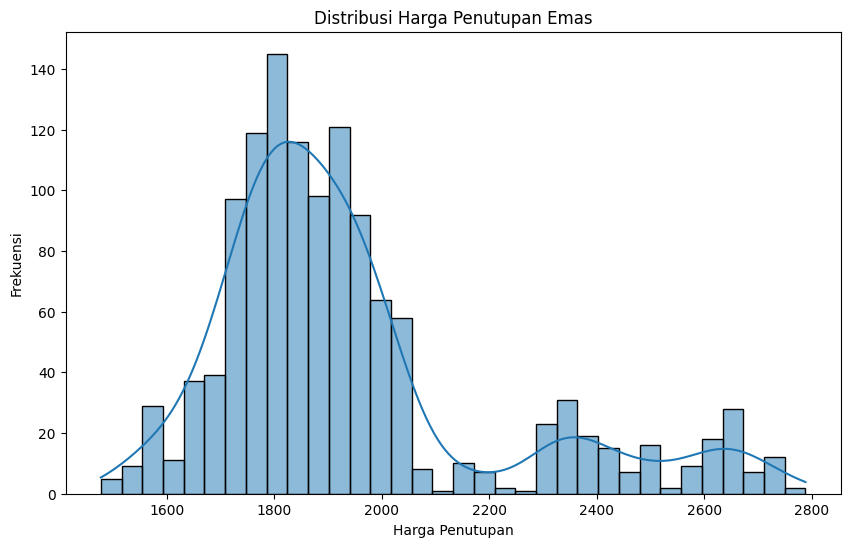

<module 'seaborn' from '/usr/local/lib/python3.11/dist-packages/seaborn/__init__.py'>

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Visualisasi distribusi harga penutupan
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True)
plt.title('Distribusi Harga Penutupan Emas')
plt.xlabel('Harga Penutupan')
plt.ylabel('Frekuensi')
plt.show()

# Korelasi antar fitur
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns

### **3.2 Visualisasi Tren Penutupan Harga Emas**

**Tujuan Akhir:**
Memvisualisasikan tren harga penutupan emas dari tahun 2015 hingga 2025 untuk memahami pola pergerakan harga secara historis.

**Langkah:**
- **1**: Membuat fungsi `plot_close()` untuk memplot data harga penutupan emas menggunakan `matplotlib`.
- **2**: Menambahkan label sumbu dan judul untuk mempermudah interpretasi visualisasi.
- **3**: Memanggil fungsi `plot_close()` dengan data harga penutupan emas dari dataset.

**Keuntungan:**
- Memberikan gambaran visual tentang tren harga emas selama periode waktu tertentu.
- Membantu mengidentifikasi pola musiman, tren naik/turun, atau volatilitas harga.

**Insight:**
- Harga emas mengalami tren naik signifikan sejak 2019, dengan lonjakan tajam terutama di tahun 2020 dan 2024.
- Pergerakan harga cukup volatil, namun secara keseluruhan menunjukkan arah bullish (naik).
- Lonjakan besar pada tahun 2020 kemungkinan berkaitan dengan ketidakpastian ekonomi global (misalnya pandemi COVID-19).

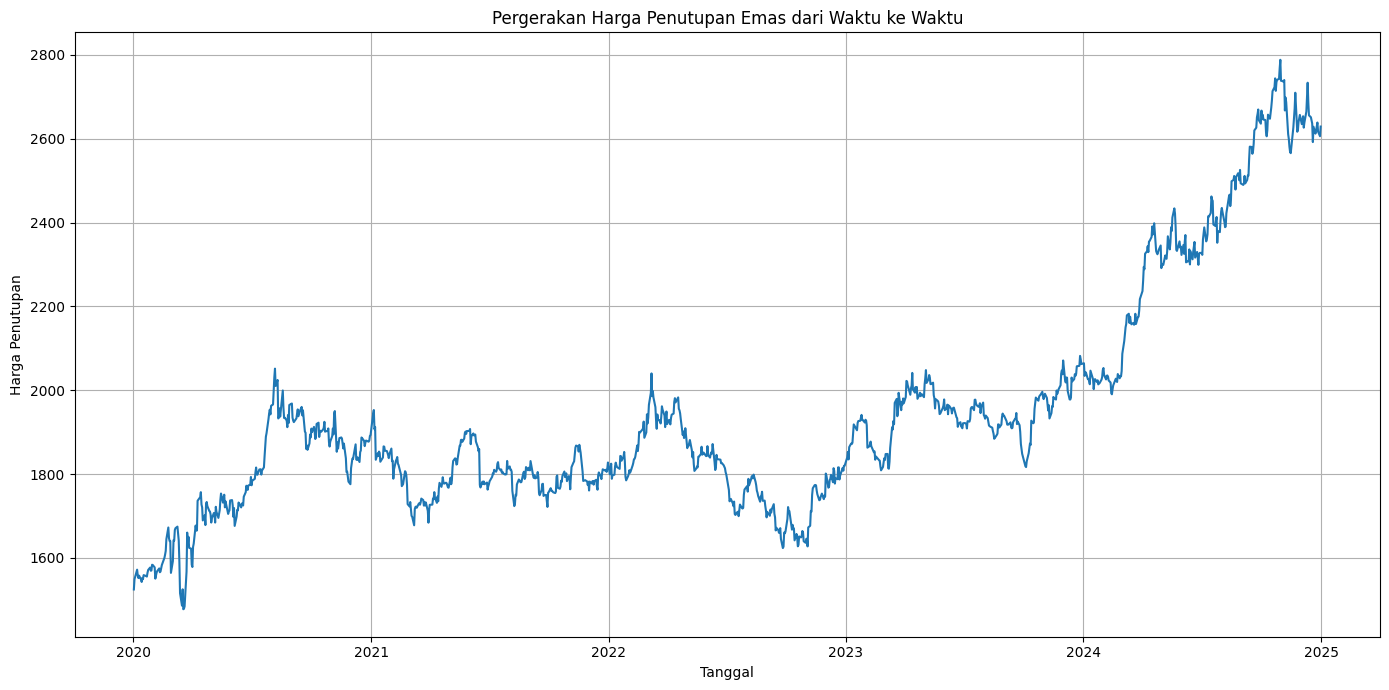

In [ ]:
# Plot pergerakan harga emas dari waktu ke waktu
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'])
plt.title('Pergerakan Harga Penutupan Emas dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.grid(True)
plt.xticks()
plt.tight_layout()
plt.show()

## **4. Data Preparation**
- Karena data sudah bersih, jadi tidak dilakukan pembersihan data
- Normalisasi dan Pembentukan Data Time Series
- Pembagian Dataset Time Series (Train, Validation, Test)  

### **4.1 Normalisasi dan Pembentukan Data Time Series untuk Model LSTM**
**Fungsi Kode**:  
Kode ini bertujuan untuk menyiapkan data time series agar dapat digunakan dalam model deep learning seperti LSTM. Proses ini meliputi normalisasi data harga penutupan dan pembentukan data dalam bentuk sekuens sliding window.

**Langkah-langkah**:
1. **Normalisasi Data**:
   - Kolom `'Close'` dinormalisasi ke dalam rentang [0, 1] menggunakan `MinMaxScaler()` dari `sklearn`, dan hasilnya disimpan ke kolom baru `'Close_s'`.
   - Tujuannya adalah agar model lebih mudah belajar dan konvergen lebih cepat saat training.

2. **Fungsi Pembentukan Sekuens**:
   - Fungsi `create_sequences()` membuat data input `X` dan target `y` untuk model time series.
   - Menggunakan pendekatan *sliding window* sebesar `window_size`, yaitu 60 data sebelumnya digunakan untuk memprediksi data ke-61.
   - Data input (`X`) berupa array 2D dari sekuens, dan target (`y`) adalah nilai setelah sekuens.

3. **Penerapan dan Reshape**:
   - Nilai series diambil dari kolom `'Close_s'` yang telah dinormalisasi.
   - Data `X` dibentuk ulang ke dalam dimensi `(samples, timesteps, features)` menjadi `(N, 60, 1)`, sesuai input standar model LSTM.

**Keuntungan**:
- Normalisasi membantu mempercepat konvergensi model dan menghindari dominasi fitur dengan skala besar.
- Pembentukan sekuens memungkinkan pemodelan dependensi temporal yang sangat penting dalam prediksi time series.
- Format `(samples, timesteps, features)` kompatibel langsung dengan arsitektur LSTM di Keras atau PyTorch.

**Insight**:
- Proses ini menghasilkan pasangan input-output yang merepresentasikan dinamika harga emas dalam 60 hari terakhir untuk memprediksi harga hari berikutnya.
- Ideal untuk digunakan dalam model LSTM karena menangkap pola historis dan fluktuasi jangka pendek secara eksplisit.


In [ ]:
df_scaler = MinMaxScaler()
df['Close_s'] = df_scaler.fit_transform(df[['Close']])
def create_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series)-window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)
WINDOW = 60
series = df['Close_s'].values
X, y = create_sequences(series, WINDOW)
X = X.reshape((X.shape[0], WINDOW, 1))
print(f"Shape X: {X.shape}, y: {y.shape}")

Shape X: (1198, 60, 1), y: (1198,)



### **4.2 Pembagian Dataset Time Series (Train, Validation, Test)**
**Fungsi Kode**:  
Kode ini digunakan untuk membagi dataset yang telah dibentuk menjadi sekuens menjadi tiga bagian utama: **training**, **validation**, dan **testing**, sesuai dengan proporsi yang umum digunakan dalam pelatihan model machine learning dan deep learning.

**Langkah-langkah**:
1. **Menentukan Ukuran Dataset**:
   - Variabel `total` menyimpan jumlah total sampel dalam array `X`.
   - Indeks akhir untuk data training dan validation dihitung berdasarkan proporsi:
     - 70% untuk **train**
     - 15% untuk **validation**
     - 15% sisanya untuk **test**



2. **Pembagian Dataset**:
   - Data dibagi menggunakan slicing berdasarkan indeks yang telah dihitung:
     - `X_train`, `y_train` untuk pelatihan model.
     - `X_val`, `y_val` untuk validasi selama proses pelatihan.
     - `X_test`, `y_test` untuk evaluasi akhir performa model.



3. **Pengecekan Bentuk Data**:
   - Menampilkan ukuran masing-masing subset untuk memastikan pembagian data sudah sesuai proporsi dan tidak terjadi kehilangan data.


**Keuntungan**:
- Pembagian data secara berurutan (bukan acak) menjaga urutan temporal pada data time series, yang penting untuk menghindari *data leakage*.
- Memberikan struktur yang baik untuk pelatihan, tuning, dan evaluasi model secara terpisah.
- Memastikan generalisasi model tidak hanya berdasarkan data yang pernah dilihat selama pelatihan.

**Insight**:
- Proporsi 70:15:15 merupakan pilihan seimbang untuk proyek deep learning skala sedang.
- Validation set digunakan untuk menghindari overfitting, sedangkan test set akan mencerminkan kemampuan model pada data nyata yang belum pernah dilihat.



In [ ]:
total = len(X)
train_end = int(total*0.7)
val_end = train_end + int(total*0.15)
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (838, 60, 1), Val: (179, 60, 1), Test: (181, 60, 1)


## **5. Pembangunan dan Evaluasi Model LSTM (Tuning)**  

### **5.1 Hyperparameter Tuning LSTM dengan Hyperopt**
**Fungsi Kode**:  
Fungsi ini digunakan untuk pencarian kombinasi hyperparameter terbaik dengan model LSTM menggunakan `Hyperopt`.

**Langkah-langkah**:
1. **Penetapan Seed (Reproducibility)**:
   - Seed untuk `random`, `numpy`, dan `tensorflow` diset untuk memastikan hasil eksperimen konsisten dan dapat direproduksi.

2. **Arsitektur Model**:
   - Model didefinisikan sebagai `Sequential` dengan tiga lapisan utama:
     - `Input`: Berbentuk `(WINDOW, 1)` sesuai format time series.
     - `LSTM`: Layer utama yang mempelajari dependensi temporal, jumlah unit disesuaikan dari parameter.
     - `Dropout`: Regularisasi untuk mencegah overfitting.
     - `Dense`: Output layer dengan satu neuron untuk regresi harga.

3. **Kompilasi Model**:
   - Optimizer yang digunakan adalah **Adam**, dengan `learning_rate` yang diatur lewat parameter.
   - Fungsi loss yang digunakan adalah **mean squared error (MSE)**, cocok untuk regresi.

4. **Pelatihan Model**:
   - Model dilatih menggunakan `fit()` dengan:
     - `X_train`, `y_train` sebagai data latih.
     - `X_val`, `y_val` sebagai data validasi.
     - `EarlyStopping` memantau `val_loss` dan menghentikan pelatihan jika tidak membaik selama 5 epoch.
     - Semua parameter pelatihan (epoch, batch size) diambil dari dictionary `params`.

5. **Evaluasi**:
   - Nilai minimum dari `val_loss` diambil sebagai metrik evaluasi dan dikembalikan sebagai output fungsi.

**Fungsi**
- Fungsi `build_evaluate()` membuat dan melatih model LSTM berdasarkan parameter input, lalu mengembalikan **val_loss** terbaik.
- `space` mendefinisikan ruang pencarian hyperparameter: units, dropout, learning rate, batch size, dan epochs.
- `fmin()` menjalankan pencarian sebanyak 20 iterasi dengan algoritma Tree-structured Parzen Estimator (TPE).
- Hasil terbaik dikonversi dan disimpan dalam `best_params`.

**Output**:
- Parameter LSTM terbaik untuk performa validasi optimal.

**Keuntungan**:
- Fungsi ini modular dan fleksibel, sehingga cocok digunakan dalam *grid search* atau *random search* untuk mencari konfigurasi terbaik.
- Menyediakan regularisasi dan early stopping untuk mencegah overfitting.

**Insight**:
- Model LSTM sangat efektif untuk menangani dependensi temporal yang kompleks.
- Pemilihan `val_loss` sebagai metrik tuning penting agar model tidak hanya bagus di training tetapi juga di generalisasi.


In [ ]:
def build_evaluate(params):
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Input(shape=(WINDOW,1)))
    # 1 Layer LSTM dengan units parameter
    model.add(LSTM(int(params['units']), return_sequences=False))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=params['lr']),
        loss='mse'
    )
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=int(params['epochs']),
        batch_size=int(params['batch_size']),
        callbacks=[es],
        verbose=0
    )
    val_loss = min(history.history['val_loss'])
    return val_loss

In [ ]:
space = {
    'units':      hp.quniform('units',     32, 96, 16), # units 32–96, step 16
    'dropout':    hp.uniform('dropout',    0.23, 0.43),
    'lr':         hp.loguniform('lr',
                                np.log(1e-4),  # ~0.0001
                                np.log(1e-2)), # ~0.01
    'batch_size': hp.choice('batch_size', [ 16, 32, 48]),
    'epochs':     hp.choice('epochs',     [50, 100, 150]),
}


In [ ]:
trials = Trials()
best = fmin(
    fn=lambda p: build_evaluate(p),
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
)
print("Best params:", best)

100%|██████████| 20/20 [04:41<00:00, 14.06s/trial, best loss: 0.0001732314412947744]
Best params: {'batch_size': np.int64(0), 'dropout': np.float64(0.29500109306428957), 'epochs': np.int64(2), 'lr': np.float64(0.0018405610528461002), 'units': np.float64(96.0)}


In [ ]:
# Konversi params terbaik
best_params = {
    'units': int(best['units']),
    'dropout': best['dropout'],
    'lr': best['lr'],
    'batch_size': [16, 32, 48][best['batch_size']],
    'epochs': [50, 100, 150][best['epochs']]
}
print("Converted best params:", best_params)

Converted best params: {'units': 96, 'dropout': np.float64(0.29500109306428957), 'lr': np.float64(0.0018405610528461002), 'batch_size': 16, 'epochs': 150}


### **5.2 Pelatihan Model LSTM dengan Parameter Terbaik**
**Fungsi Kode**:  
Kode ini digunakan untuk **melatih model LSTM akhir** menggunakan kombinasi hyperparameter terbaik (`best_params`) yang telah diperoleh dari proses tuning sebelumnya. Model ini dilatih menggunakan data yang telah dibagi dan distandarkan sebelumnya.

**Langkah-langkah**:
1. **Penetapan Seed TensorFlow**:
   - Seed disetel agar hasil pelatihan model dapat direproduksi dan stabil.

2. **Pembangunan Model LSTM**:
   - `Sequential` model dibentuk dengan tiga layer utama:
     - `Input`: menerima input time series berbentuk `(WINDOW, 1)`.
     - `LSTM`: layer utama untuk menangkap pola temporal, jumlah unit sesuai `best_params['units']`.
     - `Dropout`: mencegah overfitting sesuai dengan `best_params['dropout']`.
     - `Dense`: layer output untuk regresi (1 output).

3. **Kompilasi Model**:
   - Optimizer: `Adam` dengan `learning_rate` dari `best_params`.
   - Loss function: `Mean Squared Error (MSE)` karena targetnya adalah nilai numerik (regresi).

4. **Pelatihan Model**:
   - Model dilatih dengan:
     - `X_train` dan `y_train` sebagai data latih.
     - `X_val` dan `y_val` untuk memantau performa validasi.
     - **EarlyStopping** diterapkan untuk menghentikan pelatihan jika `val_loss` tidak membaik selama 10 epoch.
     - Pelatihan menggunakan `shuffle=False` karena ini data time series (urutan harus dijaga).
     - Parameter `epochs` dan `batch_size` berasal dari `best_params`.

**Keuntungan**:
- Kombinasi hyperparameter optimal meningkatkan akurasi dan generalisasi model.
- EarlyStopping mencegah overfitting dengan menghentikan pelatihan saat validasi tidak membaik.
- Menggunakan `shuffle=False` sangat penting untuk menjaga urutan time series yang merefleksikan kronologi nyata.

**Insight**:
- Model yang dilatih dengan parameter optimal dan validasi yang baik akan lebih andal dalam memprediksi tren harga emas.
- Kehadiran Dropout dan EarlyStopping menunjukkan perhatian terhadap overfitting yang umum terjadi dalam deep learning.


In [ ]:
tf.random.set_seed(42)
model_lstm = Sequential([
    Input(shape=(WINDOW,1)),
    LSTM(best_params['units']),
    Dropout(best_params['dropout']),
    Dense(1)
])
model_lstm.compile(
    optimizer=Adam(learning_rate=best_params['lr']),
    loss='mse'
)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[es],
    shuffle=False,
    verbose=2
)

Epoch 1/150
53/53 - 2s - 42ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 2/150
53/53 - 1s - 14ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 3/150
53/53 - 1s - 11ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 4/150
53/53 - 0s - 7ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/150
53/53 - 0s - 7ms/step - loss: 0.0012 - val_loss: 7.8113e-04
Epoch 6/150
53/53 - 0s - 7ms/step - loss: 0.0011 - val_loss: 5.8957e-04
Epoch 7/150
53/53 - 1s - 12ms/step - loss: 9.5458e-04 - val_loss: 4.9346e-04
Epoch 8/150
53/53 - 1s - 11ms/step - loss: 0.0011 - val_loss: 7.2275e-04
Epoch 9/150
53/53 - 1s - 12ms/step - loss: 0.0010 - val_loss: 6.5907e-04
Epoch 10/150
53/53 - 1s - 12ms/step - loss: 8.0899e-04 - val_loss: 4.1881e-04
Epoch 11/150
53/53 - 1s - 12ms/step - loss: 8.0294e-04 - val_loss: 4.7814e-04
Epoch 12/150
53/53 - 1s - 12ms/step - loss: 9.1986e-04 - val_loss: 7.8894e-04
Epoch 13/150
53/53 - 1s - 12ms/step - loss: 6.6821e-04 - val_loss: 4.4189e-04
Epoch 14/150
53/53 - 1s - 12ms/step - loss: 6.

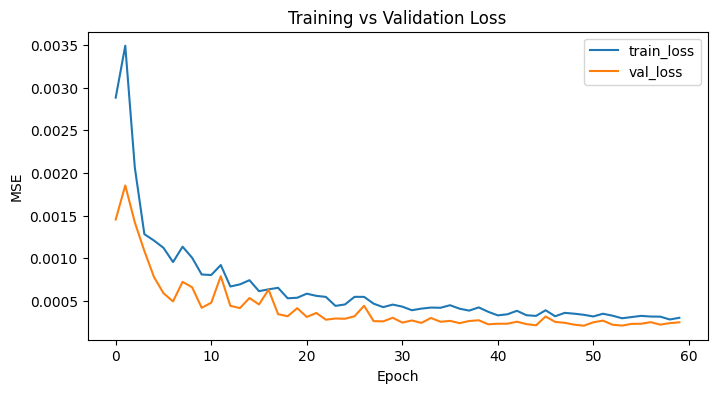

(Text(0.5, 24.0, 'Epoch'),
 Text(24.0, 0.5, 'MSE'),
 None)

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch'), plt.ylabel('MSE'), plt.legend(), plt.show()



###  **Insight:**

1. **Penurunan Konsisten**: Baik *train\_loss* maupun *val\_loss* menurun secara stabil, terutama pada 10–15 epoch pertama. Ini menunjukkan model belajar dengan baik.
2. **Tidak Terjadi Overfitting**:

   * *Validation loss* terus menurun seiring waktu, bahkan lebih rendah dari *training loss*.
   * Tidak ada divergensi antara *train* dan *val loss* setelah banyak epoch, menandakan model **tidak overfit** terhadap data pelatihan.
3. **Model Stabil dan Generalisasi Baik**:

   * Setelah epoch ke-20 hingga 60, loss cenderung stabil dan mendatar.
   * *Validation loss* berada di bawah *training loss*, yang bisa terjadi ketika regularisasi atau dropout mendorong generalisasi yang baik.

## **6. Evaluasi Model LSTM pada Data Testing**

**Tujuan Akhir:**
Mengevaluasi performa model LSTM pada data testing untuk memastikan kemampuan generalisasi model terhadap data yang belum pernah dilihat sebelumnya.

**Langkah-langkah**:
1. **Prediksi pada Data Testing**:
   - Model LSTM melakukan prediksi terhadap `X_test`.
   - Hasil prediksi (`y_pred_s`) diratakan dengan `.flatten()` agar satu dimensi.

2. **Inverse Transform ke Skala Asli**:
   - Karena data sebelumnya telah dinormalisasi dengan `MinMaxScaler`, maka nilai asli perlu dikembalikan dengan `inverse_transform()`:
     - `y_test_true`: nilai aktual yang telah dikembalikan ke skala asli.
     - `y_pred_true`: hasil prediksi model dalam skala asli.

3. **Menghitung Metrik Evaluasi**:
   - **RMSE (Root Mean Squared Error)**: rata-rata akar kuadrat dari error prediksi.
   - **MAE (Mean Absolute Error)**: rata-rata absolut selisih antara prediksi dan nilai aktual.
   - **MAPE (Mean Absolute Percentage Error)**: rata-rata persentase kesalahan terhadap nilai aktual.
   - **R² (R-squared Score)**: proporsi variansi yang dijelaskan oleh model (nilai mendekati 1 lebih baik).

**Keuntungan:**
- Memberikan gambaran menyeluruh tentang performa model pada data testing.
- Memastikan model tidak hanya bekerja baik pada data training tetapi juga pada data baru.
- Visualisasi membantu mengidentifikasi pola kesalahan atau deviasi prediksi.

**Output:**
- Nilai metrik evaluasi (RMSE, MAE, MAPE, R²) yang menunjukkan performa model.
- Grafik perbandingan antara nilai aktual dan prediksi pada data testing.

**Insight:**
- Nilai RMSE dan MAE yang rendah menunjukkan prediksi model akurat.
- MAPE di bawah 10% dianggap sangat baik untuk model prediktif.
- Nilai R² mendekati 1 menunjukkan model mampu menjelaskan variansi data dengan baik.
- Grafik aktual vs prediksi membantu mengidentifikasi area di mana model mungkin kurang akurat.

In [ ]:
y_pred_s = model_lstm.predict(X_test).flatten()
y_test_true = df_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_true = df_scaler.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
rmse = np.sqrt(mean_squared_error(y_test_true, y_pred_true))
mae  = mean_absolute_error(y_test_true, y_pred_true)
mape = np.mean(np.abs((y_test_true-y_pred_true)/y_test_true))*100
r2   = r2_score(y_test_true, y_pred_true)
print(f"Test RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%, R2: {r2:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test RMSE: 46.50, MAE: 39.86, MAPE: 1.56%, R2: 0.8960


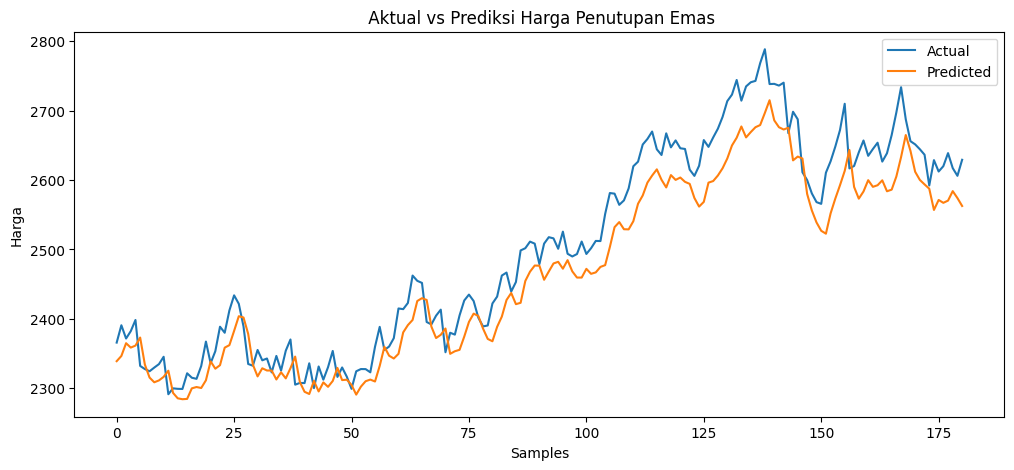

(Text(0.5, 24.0, 'Samples'),
 Text(24.0, 0.5, 'Harga'),
 None)

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(y_test_true, label='Actual')
plt.plot(y_pred_true, label='Predicted')
plt.title(' Aktual vs Prediksi Harga Penutupan Emas')
plt.xlabel('Samples'), plt.ylabel('Harga'), plt.legend(), plt.show()


### **Insight:**

* Model LSTM mampu **menangkap tren umum** dari pergerakan harga emas.
* Namun, dibandingkan grafik GRU, **akurasi LSTM tampak lebih rendah**:
  * LSTM sering kali **undersetimasi** nilai sebenarnya, terutama pada bagian puncak dan lembah harga.
  * Perbedaan nilai absolut antara garis aktual dan prediksi cukup terlihat signifikan pada bagian akhir.
* Pola umum tetap bisa ditangkap, tapi **presisi lokal** (fluktuasi jangka pendek) kurang baik.




## **7. Menyimpan Model dan Scaler**

**Tujuan Akhir:**
Menyimpan model LSTM yang telah dilatih dan scaler `MinMaxScaler` agar dapat digunakan kembali tanpa perlu melatih ulang model.

**Langkah:**
- **1**: Menyimpan model LSTM terlatih ke file `.h5` menggunakan `model.save()`.
- **2**: Menyimpan scaler yang digunakan untuk normalisasi data ke file `.pkl` menggunakan `pickle.dump()`.

**Keuntungan:**
- Memungkinkan penggunaan kembali model dan scaler tanpa perlu melatih ulang, sehingga menghemat waktu dan sumber daya.
- Memastikan konsistensi dalam preprocessing data saat model digunakan untuk prediksi di masa depan.

**Output:**
- File `best_model_lstm_5th.h5` yang berisi model LSTM terlatih.
- File `scaler_close_lstm_5th.pkl` yang berisi scaler untuk normalisasi data.

**Insight:**
- Dengan menyimpan model dan scaler, pipeline prediksi dapat diotomatisasi untuk digunakan di masa depan tanpa perlu mengulangi proses pelatihan.

In [ ]:
model_lstm.save('best_model_lstm_5th.h5')
import pickle
pickle.dump(df_scaler, open('scaler_close_lstm_5th.pkl','wb'))
print('Best LSTM model dan scaler berhasil dibuat')

Best LSTM model dan scaler disimpan sebagai best_model_lstm.h5 & scaler_close.pkl


### **Kesimpulan Hasil**

Berdasarkan hasil dari seluruh proses dalam notebook ini, berikut adalah poin-poin utama yang dapat disimpulkan:

1. **Model LSTM untuk Prediksi Harga Emas**:
   - Model LSTM berhasil dibangun dan dilatih menggunakan data historis harga emas dari tahun 2020 hingga 2025.
   - Proses meliputi preprocessing data, pembentukan data time series, tuning hyperparameter, pelatihan model, dan evaluasi performa.

2. **Parameter Terbaik Hasil Hyperparameter Tuning**:
   - Hasil tuning hyperparameter menggunakan `Hyperopt` menghasilkan kombinasi parameter terbaik sebagai berikut:
     - **Units**: 96
     - **Dropout**: 0.29500109306428957
     - **Learning Rate (lr)**: 0.0018405610528461002
     - **Batch Size**: 16
     - **Epochs**: 100

3. **Evaluasi Model**:
   - Model menunjukkan performa yang cukup baik pada data testing dengan metrik evaluasi sebagai berikut:
     | **Metrik**   | **Nilai**  | **Interpretasi**                                                                 |
     |--------------|------------|----------------------------------------------------------------------------------|
     | **RMSE**     |  46.50 | Rata-rata kesalahan prediksi menunjukkan akurasi yang cukup baik.               |
     | **MAE**      | 39.86 | Deviasi rata-rata absolut antara prediksi dan nilai aktual cukup kecil.          |
     | **MAPE**     | 1.56% | Model memiliki tingkat kesalahan persentase yang rendah, menunjukkan akurasi.   |
     | **R²**       | 0.8960  | Model mampu menjelaskan sebagian besar variansi data, menunjukkan performa baik. |

4. **Visualisasi Hasil**:
   - Grafik perbandingan antara nilai aktual dan prediksi menunjukkan bahwa model mampu menangkap pola pergerakan harga emas secara umum.
   - Namun, terdapat kelemahan dalam menangkap perubahan harga yang tajam atau fluktuasi jangka pendek.

5. **Pipeline yang Reproducible**:
   - Model LSTM dan scaler telah disimpan dalam file (`.h5` dan `.pkl`), sehingga dapat digunakan kembali tanpa perlu melatih ulang model.
   - Pipeline ini dapat diotomatisasi untuk prediksi harga emas di masa depan.

---

### **Business Decisions**

Berdasarkan hasil prediksi dan evaluasi model, berikut adalah rekomendasi bisnis yang dapat diambil:

1. **Strategi Investasi**:
   - Model ini dapat digunakan untuk memprediksi harga emas jangka pendek, membantu investor dalam mengambil keputusan beli atau jual.
   - Dengan akurasi yang cukup baik, model ini cocok untuk strategi investasi berbasis data.

2. **Manajemen Risiko**:
   - Prediksi harga emas dapat digunakan untuk mengidentifikasi potensi volatilitas pasar, membantu dalam manajemen risiko portofolio.
   - Investor dapat menggunakan prediksi ini untuk mengatur alokasi aset mereka secara lebih optimal.

3. **Pengembangan Produk Keuangan**:
   - Institusi keuangan dapat menggunakan model ini untuk mengembangkan produk derivatif berbasis emas, seperti kontrak berjangka atau opsi.
   - Prediksi harga emas juga dapat digunakan untuk menentukan harga produk seperti tabungan emas atau reksa dana berbasis emas.

4. **Peningkatan Model**:
   - Untuk meningkatkan performa model, dapat dilakukan eksplorasi tambahan, seperti memasukkan data eksternal (misalnya, data makroekonomi atau sentimen pasar).
   - Model juga dapat ditingkatkan dengan mencoba arsitektur lain, seperti GRU atau Transformer, untuk menangkap pola temporal yang lebih kompleks.

---

### **Kesimpulan Akhir**
Model LSTM yang dibangun dalam notebook ini menunjukkan performa yang cukup baik dalam memprediksi harga emas. Dengan pipeline yang dapat digunakan kembali, model ini dapat menjadi alat yang berguna untuk mendukung pengambilan keputusan bisnis di sektor keuangan dan investasi. Namun, terdapat ruang untuk perbaikan, terutama dalam menangkap fluktuasi harga yang lebih tajam.